# Imports

In [1]:
# Import all the libraries
import datasets
from datasets import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import transformers
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load dataset

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

# Load data
dataset_folder = "D:/NIH_Chest_XRay/sample/images"
csv_file = "D:/NIH_Chest_XRay/sample/sample_labels.csv"

data = pd.read_csv(csv_file)

# Converts the format of each label in the dataframe from "LabelA|LabelB|LabelC"
# into ["LabelA", "LabelB", "LabelC"], concatenates the
# lists together and removes duplicate labels
unique_labels = np.unique(
    data["Finding_Labels"].str.split("|").aggregate(np.concatenate)
).tolist()

print(f"Dataset contains the following labels:\n{unique_labels}")

Dataset contains the following labels:
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## Extract labels and create metadata file

In [3]:
# Transform labels to n hot encoded array
label_index = {v: i for i, v in enumerate(unique_labels)}


def string_to_N_hot(string: str):
    true_index = [label_index[cl] for cl in string.split("|")]
    label = np.zeros((len(unique_labels),), dtype=float)
    label[true_index] = 1
    return label


data["labels"] = data["Finding_Labels"].apply(string_to_N_hot)

In [10]:
print(data["labels"])

0       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...
1       [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
5601    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5602    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...
5603    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
5604    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5605    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: labels, Length: 5606, dtype: object


In [4]:
# Create the metadata file to use ImageFolder from Datasets
# Going for metadata because its a multilabel classification problem

metadata_file = "D:/NIH_Chest_XRay/sample/images/metadata.jsonl"
if not os.path.isfile(metadata_file):
    data[["Image_Index", "labels"]].rename(
        columns={"Image_Index": "file_name"}
    ).to_json(dataset_folder+"/metadata.jsonl", orient="records", lines=True)

In [7]:
# Load the dataset and analyse
train_val_split = 0.2
dataset = datasets.load_dataset(
    "imagefolder",
    data_dir=dataset_folder,
)

split = dataset["train"].train_test_split(train_val_split)
train_dataset = split["train"]
test_dataset = split["test"]

Resolving data files:   0%|          | 0/5607 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/mriya/.cache/huggingface/datasets/imagefolder/default-ba6ff5ebcea02f82/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(dataset.head(10))

        Image_Index                                     Finding_Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   
5  00000040_003.png                                 Consolidation|Mass   
6  00000042_002.png                                         No Finding   
7  00000057_001.png                                         No Finding   
8  00000061_002.png                                           Effusion   
9  00000061_019.png                                         No Finding   

   Follow-up #  Patient_ID Patient_Age Patient_Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y     

In [11]:
from collections import Counter
import numpy as np

# Assuming you have loaded and split the dataset
train_dataset = dataset["train"]

# Initialize a Counter to count occurrences of each label
label_counter = Counter()

# Loop through the train dataset and count labels
for example in train_dataset:
    labels = example["labels"]
    label_indices = np.where(labels)[0]  # Get indices of active labels
    label_counter.update(label_indices)

# Print the count for each label
for label, count in label_counter.items():
    print(f"Label {label}: {count} samples")


Label 10: 2439 samples
Label 0: 399 samples
Label 8: 788 samples
Label 2: 172 samples
Label 11: 249 samples
Label 3: 102 samples
Label 13: 49 samples
Label 9: 222 samples
Label 4: 499 samples
Label 12: 140 samples
Label 14: 210 samples
Label 5: 97 samples
Label 1: 113 samples
Label 6: 68 samples
Label 7: 10 samples


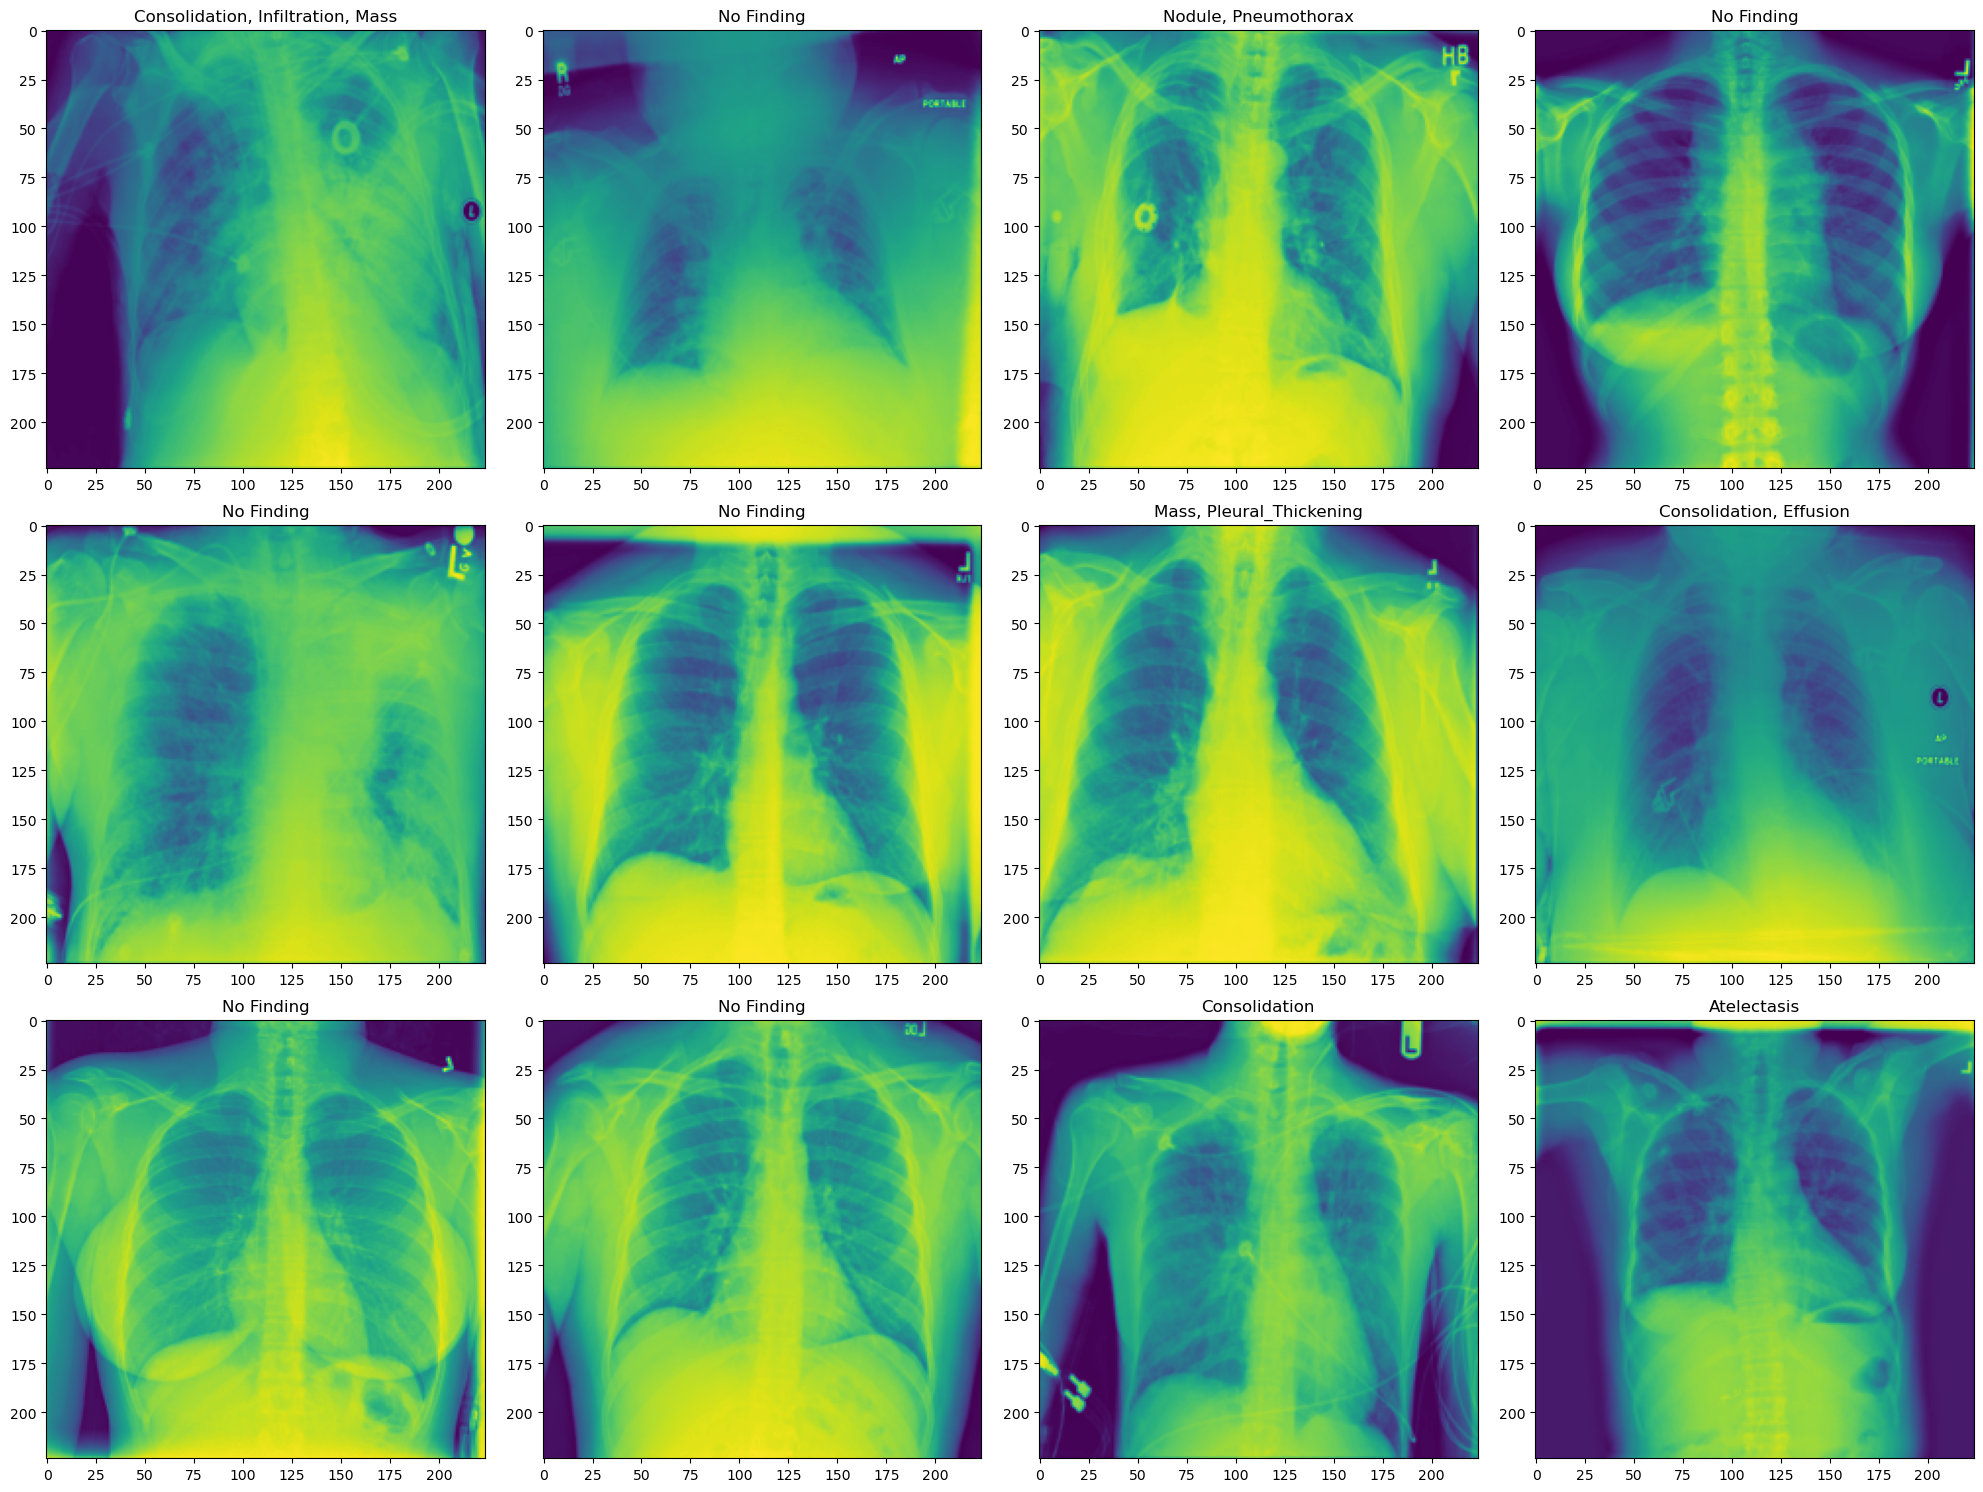

In [11]:
fig = plt.figure(figsize=(20, 15))

unique_labels = np.array(unique_labels)

convert_image_to_float = transforms.ConvertImageDtype(dtype=torch.float32)
for i, data_dict in enumerate(dataset["validation"]):
    if i == 12:
        break
    image = data_dict["pixel_values"]
    # Convert image to format supported by imshow
    image = convert_image_to_float(image)
    label = data_dict["labels"]
    ax = plt.subplot(3, 4, i + 1)
    ax.set_title(", ".join(unique_labels[np.argwhere(label).flatten()]))
    plt.imshow(image[0])  # Plot only the first channel as they are all identical

fig.tight_layout()

C:\Users\mriya\AppData\Local\Temp\ipykernel_17992\1656880041.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((240, 240), Image.ANTIALIAS)


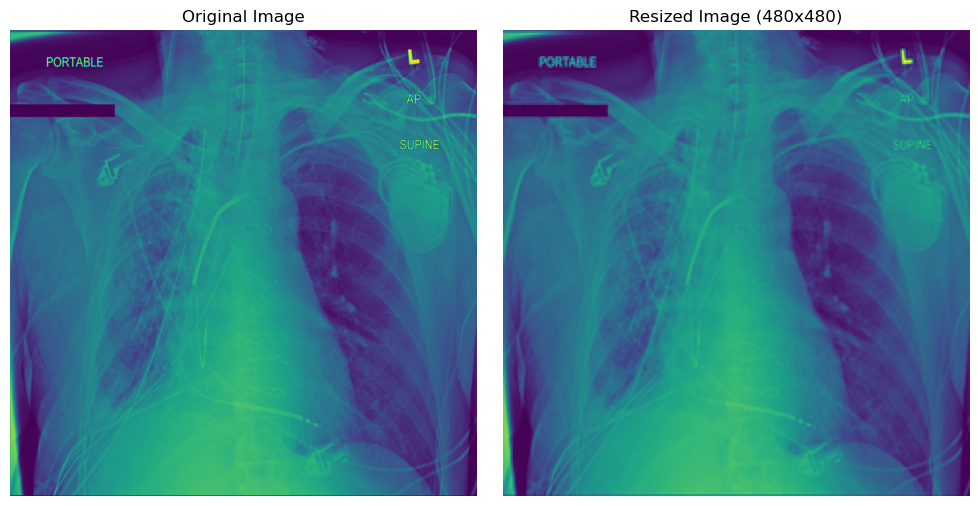

In [7]:
def resize_and_squish_image(image_path, new_width, new_height):
    # Open the image using PIL
    img = Image.open(image_path)
    
    # Get the original size of the image
    original_width, original_height = img.size
    
    # Calculate the new height to maintain the aspect ratio
    #new_height = int(new_width * (original_height / original_width))
    
    # Resize the image to the new dimensions (480x480)
    #img_resized = img.resize((new_width, new_height), Image.ANTIALIAS)
    img_resized = img.resize((240, 240), Image.ANTIALIAS)
    
    return img, img_resized

# Example usage
image_path = "D:/NIH_Chest_XRay/sample/images/00000013_005.png"
new_width = 224
new_height = 224
original_image, resized_image = resize_and_squish_image(image_path, new_width, new_height)

# Display the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(resized_image)
axes[1].set_title("Resized Image (480x480)")
axes[1].axis("off")

plt.tight_layout()
plt.show()